# 5. Importance Sampling for Neural Network Training

In this notebook, we explore **importance sampling** as a technique for improving neural network inference on extreme parameter values. Specifically, we address the problem where neural networks trained on AR(1) data struggle with extreme cases like $\rho \approx 0.9999$ or $\sigma \approx 0.001$.

## The Problem: Rare Events in Training

In `working_4.ipynb`, we trained a neural network to estimate the posterior mean of AR(1) parameters:
$$X_t = \rho X_{t-1} + \epsilon_t \quad \text{where} \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)$$

Our training procedure was:
1. Sample parameters from the **prior**: $\rho \sim \mathcal{U}(-1, 1)$, $\sigma \sim \mathcal{U}(0, A)$
2. Simulate time series data $\vec{x}$ given these parameters
3. Train the neural network to predict $(\rho, \sigma)$ from $\vec{x}$
4. Use MSE loss: $L = (\hat{\rho} - \rho)^2 + (\hat{\sigma} - \sigma)^2$

### Why This Fails for Extreme Values

When we sample uniformly from the prior:
- Extreme values like $\rho = 0.99$ occur with the **same frequency** as moderate values like $\rho = 0.5$
- But in practice, we care more about getting extreme values right (they're harder and more informative)
- The neural network sees all regions equally, so doesn't specialize on difficult cases

Additionally:
- The data $\vec{x}$ generated from extreme parameters can look very different (high autocorrelation, small variance)
- These edge cases need more training examples to learn properly
- But they appear rarely in our uniform sampling scheme

## The Solution: Importance Sampling in Training

The key insight is that we can **oversample extreme regions** during training, then **reweight the loss** to correct for this bias.

Instead of sampling from the prior $p(\theta)$, we:
1. Sample from a **proposal distribution** $q(\theta)$ that oversamples extreme values
2. Compute **importance weights**: $w(\theta) = \frac{p(\theta)}{q(\theta)}$
3. Use a **weighted loss**: $L_{\text{weighted}} = w(\theta) \cdot L(\theta)$

This ensures:
- The neural network sees more extreme examples
- But we still train on the correct distribution (via weighting)
- The network learns to handle difficult cases better

## Mathematical Foundation

### Standard Neural Network Training

We want our neural network $f_\phi(\vec{x})$ to minimize the expected squared error:
$$
\mathcal{L}(\phi) = \mathbb{E}_{\theta \sim p, \vec{x} \sim p(\cdot|\theta)}\left[(f_\phi(\vec{x}) - \theta)^2\right]
$$

In practice, we approximate this with Monte Carlo sampling:
$$
\mathcal{L}(\phi) \approx \frac{1}{N} \sum_{i=1}^N (f_\phi(\vec{x}_i) - \theta_i)^2
$$
where $\theta_i \sim p(\theta)$ and $\vec{x}_i \sim p(\vec{x} | \theta_i)$.

### Importance Sampling Modification

Now suppose we sample $\theta$ from a different distribution $q(\theta)$ instead of $p(\theta)$. We can rewrite the expectation:
$$
\begin{aligned}
\mathcal{L}(\phi) &= \mathbb{E}_{\theta \sim p}\left[\mathbb{E}_{\vec{x} \sim p(\cdot|\theta)}\left[(f_\phi(\vec{x}) - \theta)^2\right]\right] \\
&= \int p(\theta) \mathbb{E}_{\vec{x} | \theta}\left[(f_\phi(\vec{x}) - \theta)^2\right] d\theta \\
&= \int \frac{p(\theta)}{q(\theta)} q(\theta) \mathbb{E}_{\vec{x} | \theta}\left[(f_\phi(\vec{x}) - \theta)^2\right] d\theta \\
&= \mathbb{E}_{\theta \sim q}\left[w(\theta) \cdot \mathbb{E}_{\vec{x} | \theta}\left[(f_\phi(\vec{x}) - \theta)^2\right]\right]
\end{aligned}
$$

where $w(\theta) = \frac{p(\theta)}{q(\theta)}$ is the **importance weight**.

### Monte Carlo Estimator with Importance Sampling

This gives us a new Monte Carlo estimator:
$$
\mathcal{L}(\phi) \approx \frac{1}{N} \sum_{i=1}^N w(\theta_i) \cdot (f_\phi(\vec{x}_i) - \theta_i)^2
$$
where now $\theta_i \sim q(\theta)$ (our proposal).

This is an **unbiased** estimator of the true loss, even though we're sampling from $q$ instead of $p$!

## Self-Normalized Importance Sampling

In practice, we might not know the normalizing constants for $p$ and $q$. For example:
- We know $p(\theta) = \frac{1}{2A}$ for $\theta = (\rho, \sigma)$ with $\rho \in (-1,1)$ and $\sigma \in (0,A)$
- But if $q$ is more complex, we might only know it up to a constant

In this case, we use **self-normalized importance sampling**:
$$
\mathcal{L}_{\text{SNIS}}(\phi) = \frac{\sum_{i=1}^N w(\theta_i) \cdot (f_\phi(\vec{x}_i) - \theta_i)^2}{\sum_{i=1}^N w(\theta_i)}
$$

This is slightly **biased** for finite $N$, but:
- The bias vanishes as $N \to \infty$
- It's much more stable numerically
- It handles unnormalized distributions automatically

## Batch-wise Implementation

In practice, we train neural networks with **mini-batches** using gradient descent. For each batch:

1. Sample $\theta_1, \ldots, \theta_B$ from proposal $q(\theta)$
2. Generate data $\vec{x}_1, \ldots, \vec{x}_B$ from $p(\vec{x} | \theta_i)$
3. Compute importance weights $w_i = p(\theta_i) / q(\theta_i)$
4. Compute weighted loss:
   $$L_{\text{batch}} = \frac{\sum_{i=1}^B w_i \cdot (f_\phi(\vec{x}_i) - \theta_i)^2}{\sum_{i=1}^B w_i}$$
5. Backpropagate and update $\phi$

The key difference from standard training is the **reweighting in step 4**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import stats

np.random.seed(42)
torch.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## AR(1) Model Setup

First, let's set up our AR(1) problem with the same helper functions from working_4.

In [ ]:
A = 5.0  # Upper bound for sigma
T = 64   # Time series length

def simulate_ar1_batch(rho, sigma, T, batch_size, device='cpu'):
    """Vectorized AR(1) simulation for a batch"""
    eps = torch.randn(batch_size, T, device=device) * sigma[:, None]
    
    # Add numerical stability: clamp rho and add epsilon
    rho_safe = torch.clamp(rho, -0.9999, 0.9999)
    x0 = torch.randn(batch_size, device=device) * sigma / torch.sqrt(1 - rho_safe**2 + 1e-8)
    
    x = torch.zeros(batch_size, T, device=device)
    x[:, 0] = rho * x0 + eps[:, 0]
    
    for t in range(1, T):
        x[:, t] = rho * x[:, t-1] + eps[:, t]
    
    return x

## Designing the Proposal Distribution

We want to oversample extreme values of $\rho$ (near $\pm 1$) and extreme values of $\sigma$ (near 0 or near $A$).

### Strategy: Beta Distribution for ρ

Instead of $\rho \sim \mathcal{U}(-1, 1)$, we'll use a **Beta distribution** that can concentrate density near the boundaries.

Recall that $\text{Beta}(\alpha, \beta)$ on $[0,1]$:
- Has mean $\mu = \frac{\alpha}{\alpha + \beta}$
- When $\alpha < 1$ or $\beta < 1$, it has heavy tails (density increases near 0 or 1)
- When $\alpha = \beta = 0.5$, it's U-shaped (concentrates near boundaries)

We'll sample $\tilde{\rho} \sim \text{Beta}(\alpha, \alpha)$ on $[0,1]$, then transform to $[-1, 1]$:
$$\rho = 2\tilde{\rho} - 1$$

### Strategy: Beta Distribution for σ

Similarly, for $\sigma \in (0, A)$, we sample $\tilde{\sigma} \sim \text{Beta}(\beta_1, \beta_2)$ and transform:
$$\sigma = A \cdot \tilde{\sigma}$$

With $\beta_1 < 1$ or $\beta_2 < 1$, we oversample values near 0 or near $A$.

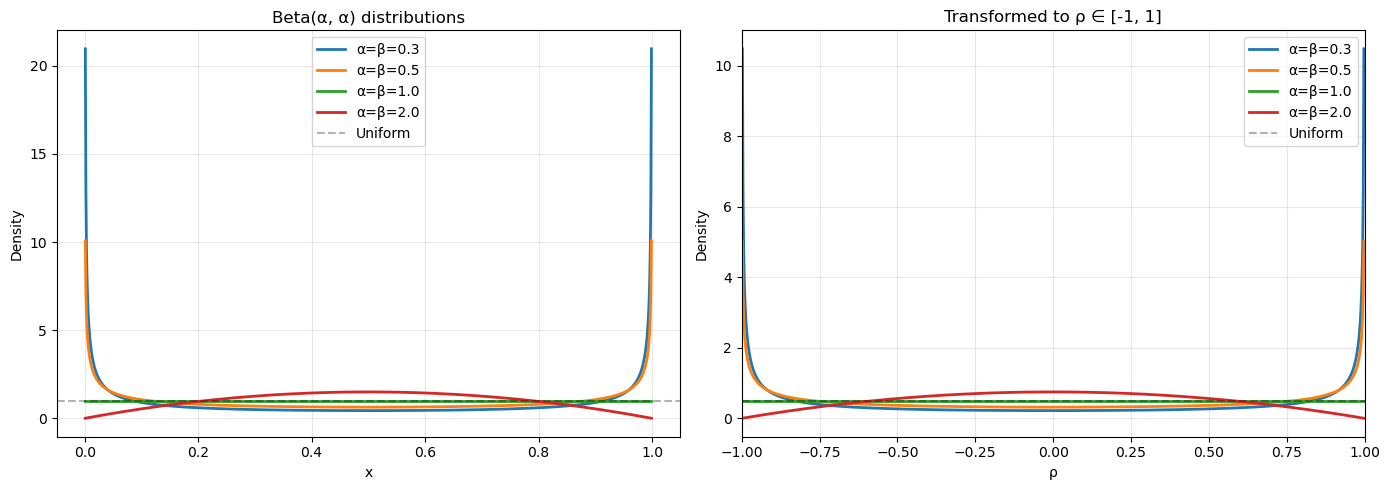

Note: α < 1 creates U-shaped distributions that oversample extreme values!


In [3]:
# Visualize different Beta distributions
x = np.linspace(0.001, 0.999, 1000)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Different Beta shapes
for alpha in [0.3, 0.5, 1.0, 2.0]:
    pdf = stats.beta.pdf(x, alpha, alpha)
    axes[0].plot(x, pdf, label=f'α=β={alpha}', linewidth=2)

axes[0].axhline(1.0, color='black', linestyle='--', alpha=0.3, label='Uniform')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].set_title('Beta(α, α) distributions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After transformation to [-1, 1]
rho_range = 2 * x - 1
for alpha in [0.3, 0.5, 1.0, 2.0]:
    pdf = stats.beta.pdf(x, alpha, alpha) / 2  # Jacobian = 2
    axes[1].plot(rho_range, pdf, label=f'α=β={alpha}', linewidth=2)

axes[1].axhline(0.5, color='black', linestyle='--', alpha=0.3, label='Uniform')
axes[1].set_xlabel('ρ')
axes[1].set_ylabel('Density')
axes[1].set_title('Transformed to ρ ∈ [-1, 1]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([-1, 1])

plt.tight_layout()
plt.show()

print("Note: α < 1 creates U-shaped distributions that oversample extreme values!")

## Computing Importance Weights

For our proposal, we need to compute the density ratio $w(\theta) = \frac{p(\theta)}{q(\theta)}$.

### Prior (Target) Distribution
$$
p(\rho, \sigma) = \frac{1}{2} \cdot \frac{1}{A} = \frac{1}{2A}
$$
for $\rho \in (-1, 1)$ and $\sigma \in (0, A)$.

### Proposal Distribution
We sample:
- $\tilde{\rho} \sim \text{Beta}(\alpha_\rho, \alpha_\rho)$, then $\rho = 2\tilde{\rho} - 1$
- $\tilde{\sigma} \sim \text{Beta}(\alpha_\sigma, \beta_\sigma)$, then $\sigma = A \cdot \tilde{\sigma}$

The density is:
$$
q(\rho, \sigma) = q_\rho(\rho) \cdot q_\sigma(\sigma)
$$

where (using change of variables):
$$
\begin{aligned}
q_\rho(\rho) &= \frac{1}{2} \cdot \text{Beta}\left(\frac{\rho + 1}{2}; \alpha_\rho, \alpha_\rho\right) \\
q_\sigma(\sigma) &= \frac{1}{A} \cdot \text{Beta}\left(\frac{\sigma}{A}; \alpha_\sigma, \beta_\sigma\right)
\end{aligned}
$$

### Importance Weight
$$
w(\rho, \sigma) = \frac{p(\rho, \sigma)}{q(\rho, \sigma)} = \frac{1}{\text{Beta}\left(\frac{\rho + 1}{2}; \alpha_\rho, \alpha_\rho\right) \cdot \text{Beta}\left(\frac{\sigma}{A}; \alpha_\sigma, \beta_\sigma\right)}
$$

In [4]:
def sample_from_proposal(batch_size, alpha_rho=0.5, alpha_sigma=0.5, beta_sigma=0.5, A=5.0, device='cpu'):
    """
    Sample (rho, sigma) from Beta-based proposal
    
    Args:
        alpha_rho: Beta parameter for rho (symmetric Beta(alpha_rho, alpha_rho))
        alpha_sigma, beta_sigma: Beta parameters for sigma
    """
    # Sample from Beta distributions
    rho_tilde = np.random.beta(alpha_rho, alpha_rho, size=batch_size)
    sigma_tilde = np.random.beta(alpha_sigma, beta_sigma, size=batch_size)
    
    # Transform to parameter ranges
    rho = 2 * rho_tilde - 1
    sigma = A * sigma_tilde
    
    # Convert to tensors
    rho = torch.tensor(rho, dtype=torch.float32, device=device)
    sigma = torch.tensor(sigma, dtype=torch.float32, device=device)
    
    return rho, sigma

def compute_importance_weights(rho, sigma, alpha_rho=0.5, alpha_sigma=0.5, beta_sigma=0.5, A=5.0):
    """
    Compute importance weights w = p(theta) / q(theta)
    
    Returns weights as a numpy array
    """
    # Convert to numpy if tensors
    if torch.is_tensor(rho):
        rho = rho.cpu().numpy()
        sigma = sigma.cpu().numpy()
    
    # Transform back to [0, 1]
    rho_tilde = (rho + 1) / 2
    sigma_tilde = sigma / A
    
    # Proposal densities (Beta PDFs)
    q_rho = stats.beta.pdf(rho_tilde, alpha_rho, alpha_rho) / 2  # Jacobian = 1/2
    q_sigma = stats.beta.pdf(sigma_tilde, alpha_sigma, beta_sigma) / A  # Jacobian = 1/A
    
    q_theta = q_rho * q_sigma
    
    # Prior density (uniform)
    p_theta = 1.0 / (2 * A)
    
    # Importance weights
    weights = p_theta / q_theta
    
    return weights

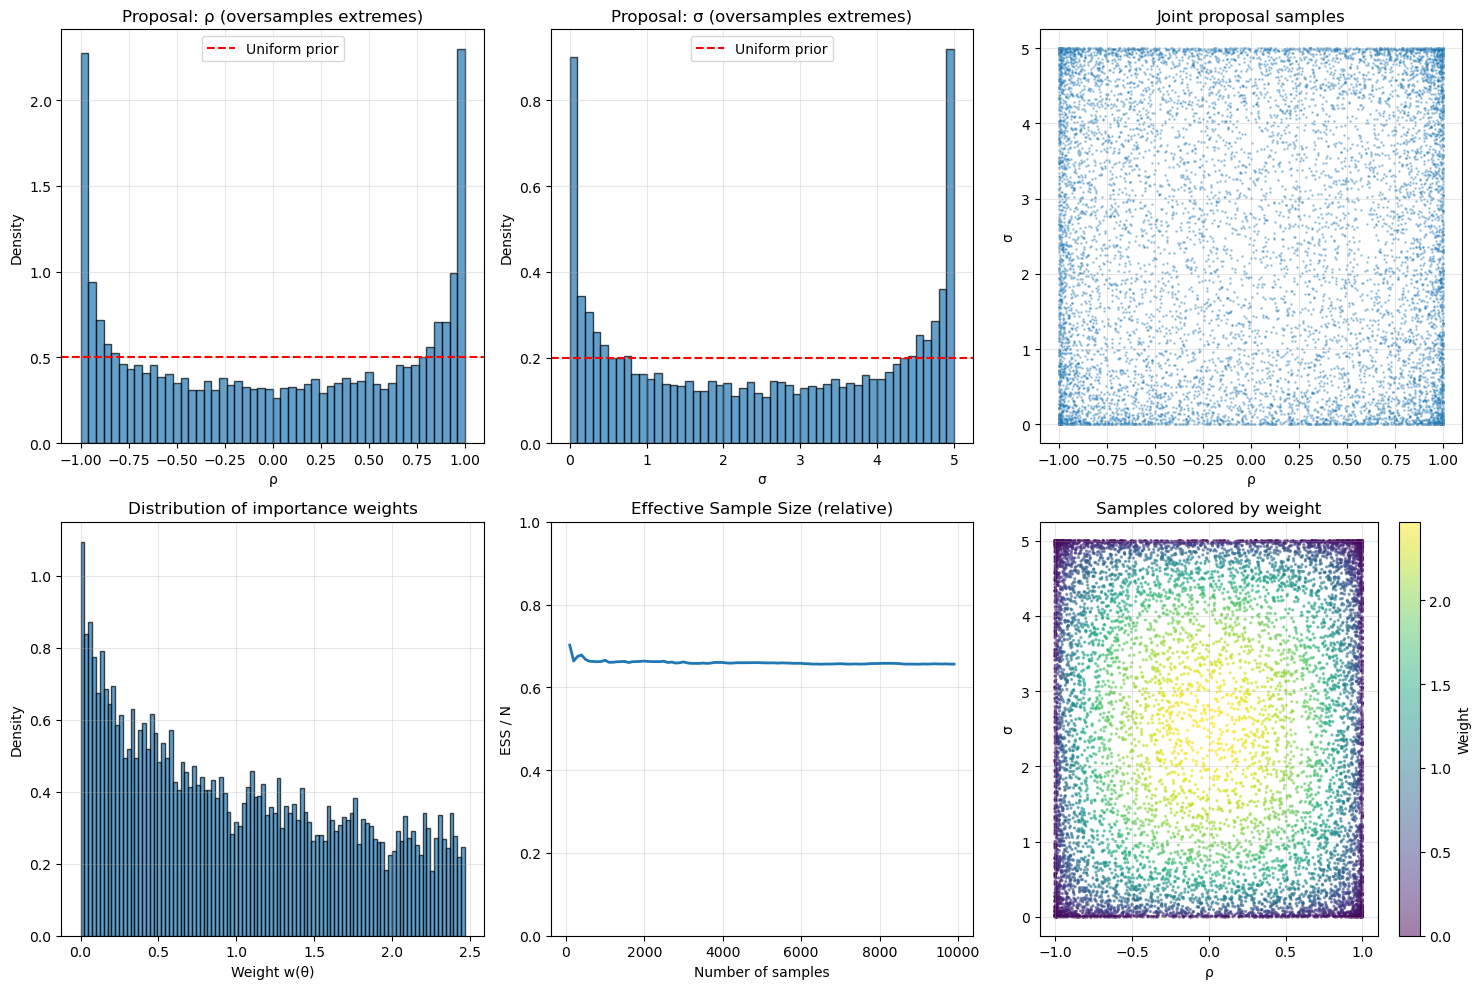

Weight statistics:
  Mean: 0.9956
  Std:  0.7202
  Min:  0.0000
  Max:  2.4673
  ESS:  6565 / 10000 (65.7%)


In [5]:
# Test the proposal and visualize
n_test = 10000
rho_prop, sigma_prop = sample_from_proposal(
    n_test, 
    alpha_rho=0.5, 
    alpha_sigma=0.5, 
    beta_sigma=0.5,
    A=A,
    device='cpu'
)

weights = compute_importance_weights(
    rho_prop, sigma_prop,
    alpha_rho=0.5,
    alpha_sigma=0.5,
    beta_sigma=0.5,
    A=A
)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Marginal for rho
axes[0, 0].hist(rho_prop.cpu().numpy(), bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 0].axhline(0.5, color='r', linestyle='--', label='Uniform prior')
axes[0, 0].set_xlabel('ρ')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Proposal: ρ (oversamples extremes)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Marginal for sigma
axes[0, 1].hist(sigma_prop.cpu().numpy(), bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 1].axhline(1/A, color='r', linestyle='--', label='Uniform prior')
axes[0, 1].set_xlabel('σ')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Proposal: σ (oversamples extremes)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Joint scatter
axes[0, 2].scatter(rho_prop.cpu().numpy(), sigma_prop.cpu().numpy(), 
                   s=1, alpha=0.3)
axes[0, 2].set_xlabel('ρ')
axes[0, 2].set_ylabel('σ')
axes[0, 2].set_title('Joint proposal samples')
axes[0, 2].grid(True, alpha=0.3)

# Importance weights histogram
axes[1, 0].hist(weights, bins=100, density=True, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Weight w(θ)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Distribution of importance weights')
axes[1, 0].grid(True, alpha=0.3)

# Effective sample size over samples
ess_values = []
for n in range(100, n_test, 100):
    w = weights[:n]
    w_norm = w / w.sum()
    ess = 1 / np.sum(w_norm**2)
    ess_values.append(ess / n)

axes[1, 1].plot(range(100, n_test, 100), ess_values, linewidth=2)
axes[1, 1].set_xlabel('Number of samples')
axes[1, 1].set_ylabel('ESS / N')
axes[1, 1].set_title('Effective Sample Size (relative)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

# Scatter colored by weight
scatter = axes[1, 2].scatter(rho_prop.cpu().numpy(), sigma_prop.cpu().numpy(),
                              c=weights, s=2, alpha=0.5, cmap='viridis')
axes[1, 2].set_xlabel('ρ')
axes[1, 2].set_ylabel('σ')
axes[1, 2].set_title('Samples colored by weight')
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 2], label='Weight')

plt.tight_layout()
plt.show()

print(f"Weight statistics:")
print(f"  Mean: {weights.mean():.4f}")
print(f"  Std:  {weights.std():.4f}")
print(f"  Min:  {weights.min():.4f}")
print(f"  Max:  {weights.max():.4f}")
print(f"  ESS:  {1/np.sum((weights/weights.sum())**2):.0f} / {n_test} ({100/np.sum((weights/weights.sum())**2)/n_test:.1f}%)")

## Neural Network Architecture

We'll use the same GRU architecture from working_4, which worked well for AR(1) time series.

In [6]:
class GRUPosteriorEstimator(nn.Module):
    def __init__(
        self,
        input_dim=1,
        hidden_dim=64,
        num_layers=2,
        output_dim=2,
        mlp_hidden=64
    ):
        super().__init__()
        
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.estimator = nn.Sequential(
            nn.Linear(hidden_dim, mlp_hidden),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(mlp_hidden, output_dim)
        )
    
    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        gru_out, h_n = self.gru(x)
        last_hidden = h_n[-1]
        return self.estimator(last_hidden)

## Training: Standard vs Importance Sampling

We'll train **two models**:
1. **Standard**: Sample from uniform prior, use unweighted MSE loss
2. **Importance Sampling**: Sample from Beta proposal, use weighted MSE loss

Then compare their performance, especially on extreme parameter values.

In [ ]:
def train_standard(model, n_epochs=100, batch_size=128, lr=0.001, device='cpu', A=5.0, T=64):
    """Standard training with uniform sampling from prior"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                             factor=0.5, patience=10)
    loss_fn = nn.MSELoss()
    
    train_losses = []
    
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        n_batches = 128
        
        for _ in range(n_batches):
            # Sample from uniform prior
            rho = torch.empty(batch_size, device=device).uniform_(-1, 1)
            sigma = torch.empty(batch_size, device=device).uniform_(0, A)
            
            # Generate AR(1) data
            x = simulate_ar1_batch(rho, sigma, T, batch_size, device=device)
            
            # Forward pass
            theta_pred = model(x)
            
            # Compute loss directly on raw predictions (no transformations during training)
            loss = loss_fn(theta_pred, torch.stack([rho, sigma], axis=1))
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")
    
    return train_losses

def train_importance_sampling(model, n_epochs=100, batch_size=128, lr=0.001, 
                              alpha_rho=0.5, alpha_sigma=0.5, beta_sigma=0.5,
                              device='cpu', A=5.0, T=64):
    """Training with importance sampling"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                             factor=0.5, patience=10)
    
    train_losses = []
    
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        n_batches = 128
        
        for batch_idx in range(n_batches):
            # Sample from proposal (oversamples extremes)
            rho, sigma = sample_from_proposal(
                batch_size, alpha_rho, alpha_sigma, beta_sigma, A, device
            )
            
            # Compute importance weights
            weights = compute_importance_weights(
                rho, sigma, alpha_rho, alpha_sigma, beta_sigma, A
            )
            weights = torch.tensor(weights, dtype=torch.float32, device=device)
            
            # Replace NaN/Inf with small/large values
            weights = torch.nan_to_num(weights, nan=1.0, posinf=10.0, neginf=0.1)
            
            # CRITICAL FIX: Clamp raw weights CONSERVATIVELY to prevent extreme normalized weights
            # After normalization, max_weight/min_weight ratio will be at most 100x
            weights = torch.clamp(weights, min=0.1, max=10.0)
            
            # Normalize weights (self-normalized IS)
            weights = weights / weights.sum()
            
            # Generate AR(1) data
            x = simulate_ar1_batch(rho, sigma, T, batch_size, device=device)
            
            # Check for NaN/Inf
            if torch.isnan(x).any() or torch.isinf(x).any():
                print(f"Warning: NaN/Inf in data at epoch {epoch+1}, batch {batch_idx}, skipping")
                continue
            
            # Forward pass
            theta_pred = model(x)
            
            # Check if network output is valid
            if torch.isnan(theta_pred).any() or torch.isinf(theta_pred).any():
                print(f"Warning: NaN/Inf in predictions at epoch {epoch+1}, batch {batch_idx}, skipping")
                continue
            
            # Compute weighted loss (no transformations during training)
            loss_per_sample = ((theta_pred - torch.stack([rho, sigma], dim=1))**2).sum(dim=1)
            
            # SNIS: weighted average
            loss = torch.sum(weights * loss_per_sample)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: NaN/Inf loss at epoch {epoch+1}, batch {batch_idx}")
                print(f"  weights range: [{weights.min():.2e}, {weights.max():.2e}]")
                print(f"  loss_per_sample range: [{loss_per_sample.min():.2e}, {loss_per_sample.max():.2e}]")
                continue
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        # Monitor ESS
        if (epoch + 1) % 10 == 0:
            ess = 1.0 / torch.sum(weights**2)
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}, ESS: {ess.item():.1f}/{batch_size}")
    
    return train_losses

In [ ]:
# Train standard model
print("Training STANDARD model (uniform sampling)...")
print("="*60)
model_standard = GRUPosteriorEstimator(
    hidden_dim=64, num_layers=2, mlp_hidden=64
).to(device)

losses_standard = train_standard(
    model_standard, n_epochs=100, batch_size=128, lr=0.001,
    device=device, A=A, T=T
)

print("\n" + "="*60)
print("SANITY CHECK: Training IS model with Beta(1,1) (should match standard)...")
print("="*60)
model_is_sanity = GRUPosteriorEstimator(
    hidden_dim=64, num_layers=2, mlp_hidden=64
).to(device)

losses_is_sanity = train_importance_sampling(
    model_is_sanity, n_epochs=20, batch_size=128, lr=0.001,
    alpha_rho=1.0, alpha_sigma=1.0, beta_sigma=1.0,  # Uniform = no importance sampling
    device=device, A=A, T=T
)

print("\n" + "="*60)
print("Training IMPORTANCE SAMPLING model with Beta(0.7, 0.7)...")
print("="*60)
model_is = GRUPosteriorEstimator(
    hidden_dim=64, num_layers=2, mlp_hidden=64
).to(device)

losses_is = train_importance_sampling(
    model_is, n_epochs=100, batch_size=128, lr=0.001,
    alpha_rho=0.7, alpha_sigma=0.7, beta_sigma=0.7,
    device=device, A=A, T=T
)

In [ ]:
# DEBUG: Test one batch of IS training to identify NaN source
print("="*60)
print("DEBUGGING: Testing one IS batch...")
print("="*60)

# Sample from proposal
rho_debug, sigma_debug = sample_from_proposal(
    128, alpha_rho=0.7, alpha_sigma=0.7, beta_sigma=0.7, A=A, device=device
)

print(f"1. Sampled parameters:")
print(f"   rho range: [{rho_debug.min():.4f}, {rho_debug.max():.4f}]")
print(f"   sigma range: [{sigma_debug.min():.4f}, {sigma_debug.max():.4f}]")

# Compute importance weights
weights_debug = compute_importance_weights(
    rho_debug, sigma_debug, alpha_rho=0.7, alpha_sigma=0.7, beta_sigma=0.7, A=A
)
weights_debug = torch.tensor(weights_debug, dtype=torch.float32, device=device)

print(f"\n2. Raw importance weights:")
print(f"   min: {weights_debug.min():.2e}, max: {weights_debug.max():.2e}")
print(f"   mean: {weights_debug.mean():.2e}, std: {weights_debug.std():.2e}")
print(f"   any NaN: {torch.isnan(weights_debug).any()}")
print(f"   any Inf: {torch.isinf(weights_debug).any()}")

# Clamp weights
weights_debug_clamped = torch.clamp(weights_debug, min=1e-8, max=100.0)
print(f"\n3. Clamped weights [1e-8, 100]:")
print(f"   min: {weights_debug_clamped.min():.2e}, max: {weights_debug_clamped.max():.2e}")

# Normalize weights
weights_debug_norm = weights_debug_clamped / weights_debug_clamped.sum()
print(f"\n4. Normalized weights:")
print(f"   min: {weights_debug_norm.min():.2e}, max: {weights_debug_norm.max():.2e}")
print(f"   sum: {weights_debug_norm.sum():.4f}")
print(f"   any NaN: {torch.isnan(weights_debug_norm).any()}")
print(f"   any Inf: {torch.isinf(weights_debug_norm).any()}")

# Generate AR(1) data
x_debug = simulate_ar1_batch(rho_debug, sigma_debug, T, 128, device=device)
print(f"\n5. Generated AR(1) data:")
print(f"   x range: [{x_debug.min():.2e}, {x_debug.max():.2e}]")
print(f"   x mean: {x_debug.mean():.4f}, std: {x_debug.std():.4f}")
print(f"   any NaN: {torch.isnan(x_debug).any()}")
print(f"   any Inf: {torch.isinf(x_debug).any()}")

# Create a test model
test_model = GRUPosteriorEstimator(hidden_dim=64, num_layers=2, mlp_hidden=64).to(device)

# Forward pass
theta_pred_debug = test_model(x_debug)
print(f"\n6. Network predictions:")
print(f"   theta_pred range: [{theta_pred_debug.min():.2e}, {theta_pred_debug.max():.2e}]")
print(f"   any NaN: {torch.isnan(theta_pred_debug).any()}")
print(f"   any Inf: {torch.isinf(theta_pred_debug).any()}")

# Compute loss
loss_per_sample_debug = ((theta_pred_debug - torch.stack([rho_debug, sigma_debug], dim=1))**2).sum(dim=1)
print(f"\n7. Per-sample loss:")
print(f"   loss range: [{loss_per_sample_debug.min():.2e}, {loss_per_sample_debug.max():.2e}]")
print(f"   any NaN: {torch.isnan(loss_per_sample_debug).any()}")

# Weighted loss
loss_debug = torch.sum(weights_debug_norm * loss_per_sample_debug)
print(f"\n8. Weighted loss:")
print(f"   loss: {loss_debug:.2e}")
print(f"   is NaN: {torch.isnan(loss_debug)}")

print(f"\n9. PROBLEM IDENTIFIED:")
print(f"   Max normalized weight: {weights_debug_norm.max():.2e}")
print(f"   Max weight * max loss: {weights_debug_norm.max() * loss_per_sample_debug.max():.2e}")
print("="*60)

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(losses_standard, label='Standard (uniform)', linewidth=2)
plt.plot(losses_is, label='Importance Sampling', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Evaluation: Testing on Extreme Values

Now we evaluate both models on test sets with varying degrees of extremeness.

We'll create test sets:
1. **Moderate**: $\rho \sim \mathcal{U}(0.3, 0.7)$, $\sigma \sim \mathcal{U}(1, 3)$
2. **High ρ**: $\rho \sim \mathcal{U}(0.9, 0.99)$, $\sigma \sim \mathcal{U}(0.5, 2)$
3. **Small σ**: $\rho \sim \mathcal{U}(0.3, 0.7)$, $\sigma \sim \mathcal{U}(0.05, 0.3)$
4. **Both extreme**: $\rho \sim \mathcal{U}(0.95, 0.99)$, $\sigma \sim \mathcal{U}(0.05, 0.2)$

In [ ]:
def evaluate_on_test_set(model, rho_range, sigma_range, n_test=500, device='cpu', A=5.0, T=64):
    """Evaluate model on a specific test set"""
    model.eval()
    
    # Generate test data
    rho_true = torch.empty(n_test, device=device).uniform_(*rho_range)
    sigma_true = torch.empty(n_test, device=device).uniform_(*sigma_range)
    x_test = simulate_ar1_batch(rho_true, sigma_true, T, n_test, device=device)
    
    with torch.no_grad():
        theta_pred = model(x_test)
        # Apply transformations during evaluation (not during training)
        rho_pred = torch.tanh(theta_pred[:, 0])
        sigma_pred = torch.nn.functional.softplus(theta_pred[:, 1])
    
    # Compute errors
    error_rho = torch.abs(rho_pred - rho_true).cpu().numpy()
    error_sigma = torch.abs(sigma_pred - sigma_true).cpu().numpy()
    
    return {
        'rho_true': rho_true.cpu().numpy(),
        'sigma_true': sigma_true.cpu().numpy(),
        'rho_pred': rho_pred.cpu().numpy(),
        'sigma_pred': sigma_pred.cpu().numpy(),
        'error_rho': error_rho,
        'error_sigma': error_sigma,
        'mae_rho': error_rho.mean(),
        'mae_sigma': error_sigma.mean(),
        'mse_rho': (error_rho**2).mean(),
        'mse_sigma': (error_sigma**2).mean()
    }

# Define test scenarios
test_scenarios = [
    {'name': 'Moderate', 'rho': (0.3, 0.7), 'sigma': (1.0, 3.0)},
    {'name': 'High ρ', 'rho': (0.9, 0.99), 'sigma': (0.5, 2.0)},
    {'name': 'Small σ', 'rho': (0.3, 0.7), 'sigma': (0.05, 0.3)},
    {'name': 'Both extreme', 'rho': (0.95, 0.99), 'sigma': (0.05, 0.2)},
]

results_comparison = []

for scenario in test_scenarios:
    print(f"\nEvaluating on: {scenario['name']}")
    print(f"  ρ ∈ {scenario['rho']}, σ ∈ {scenario['sigma']}")
    
    # Standard model
    results_std = evaluate_on_test_set(
        model_standard, scenario['rho'], scenario['sigma'],
        n_test=500, device=device, A=A, T=T
    )
    
    # IS model
    results_is_model = evaluate_on_test_set(
        model_is, scenario['rho'], scenario['sigma'],
        n_test=500, device=device, A=A, T=T
    )
    
    print(f"  Standard - MAE(ρ): {results_std['mae_rho']:.4f}, MAE(σ): {results_std['mae_sigma']:.4f}")
    print(f"  IS       - MAE(ρ): {results_is_model['mae_rho']:.4f}, MAE(σ): {results_is_model['mae_sigma']:.4f}")
    
    improvement_rho = (results_std['mae_rho'] - results_is_model['mae_rho']) / results_std['mae_rho'] * 100
    improvement_sigma = (results_std['mae_sigma'] - results_is_model['mae_sigma']) / results_std['mae_sigma'] * 100
    
    print(f"  Improvement - ρ: {improvement_rho:+.1f}%, σ: {improvement_sigma:+.1f}%")
    
    results_comparison.append({
        'scenario': scenario['name'],
        'mae_rho_std': results_std['mae_rho'],
        'mae_rho_is': results_is_model['mae_rho'],
        'mae_sigma_std': results_std['mae_sigma'],
        'mae_sigma_is': results_is_model['mae_sigma'],
        'improvement_rho': improvement_rho,
        'improvement_sigma': improvement_sigma
    })

In [ ]:
# Visualize comparison
import pandas as pd

df = pd.DataFrame(results_comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(df))
width = 0.35

# MAE for rho
axes[0].bar(x - width/2, df['mae_rho_std'], width, label='Standard', alpha=0.8, edgecolor='black')
axes[0].bar(x + width/2, df['mae_rho_is'], width, label='Importance Sampling', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Test Scenario')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_title('Estimation Error: ρ')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df['scenario'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# MAE for sigma
axes[1].bar(x - width/2, df['mae_sigma_std'], width, label='Standard', alpha=0.8, edgecolor='black')
axes[1].bar(x + width/2, df['mae_sigma_is'], width, label='Importance Sampling', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Test Scenario')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Estimation Error: σ')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df['scenario'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY OF RESULTS")
print("="*80)
print(df.to_string(index=False))

## Detailed Analysis: Extreme Case

Let's zoom in on the most extreme case and visualize the predictions.

In [ ]:
# Generate extreme test set
n_extreme = 1000
rho_extreme = torch.empty(n_extreme, device=device).uniform_(0.95, 0.99)
sigma_extreme = torch.empty(n_extreme, device=device).uniform_(0.05, 0.2)
x_extreme = simulate_ar1_batch(rho_extreme, sigma_extreme, T, n_extreme, device=device)

# Predictions from both models
model_standard.eval()
model_is.eval()

with torch.no_grad():
    theta_std = model_standard(x_extreme)
    # Apply transformations during evaluation
    rho_std = torch.tanh(theta_std[:, 0]).cpu().numpy()
    sigma_std = torch.nn.functional.softplus(theta_std[:, 1]).cpu().numpy()
    
    theta_is = model_is(x_extreme)
    # Apply transformations during evaluation
    rho_is = torch.tanh(theta_is[:, 0]).cpu().numpy()
    sigma_is = torch.nn.functional.softplus(theta_is[:, 1]).cpu().numpy()

rho_true_np = rho_extreme.cpu().numpy()
sigma_true_np = sigma_extreme.cpu().numpy()

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Rho: Standard
axes[0, 0].scatter(rho_true_np, rho_std, alpha=0.5, s=10)
axes[0, 0].plot([0.95, 0.99], [0.95, 0.99], 'r--', linewidth=2, label='Perfect prediction')
axes[0, 0].set_xlabel('True ρ')
axes[0, 0].set_ylabel('Predicted ρ')
axes[0, 0].set_title(f'Standard Model: ρ (MAE={np.abs(rho_std - rho_true_np).mean():.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0.94, 1.0])
axes[0, 0].set_ylim([0.94, 1.0])

# Rho: IS
axes[0, 1].scatter(rho_true_np, rho_is, alpha=0.5, s=10, color='orange')
axes[0, 1].plot([0.95, 0.99], [0.95, 0.99], 'r--', linewidth=2, label='Perfect prediction')
axes[0, 1].set_xlabel('True ρ')
axes[0, 1].set_ylabel('Predicted ρ')
axes[0, 1].set_title(f'IS Model: ρ (MAE={np.abs(rho_is - rho_true_np).mean():.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0.94, 1.0])
axes[0, 1].set_ylim([0.94, 1.0])

# Sigma: Standard
axes[1, 0].scatter(sigma_true_np, sigma_std, alpha=0.5, s=10)
axes[1, 0].plot([0.05, 0.2], [0.05, 0.2], 'r--', linewidth=2, label='Perfect prediction')
axes[1, 0].set_xlabel('True σ')
axes[1, 0].set_ylabel('Predicted σ')
axes[1, 0].set_title(f'Standard Model: σ (MAE={np.abs(sigma_std - sigma_true_np).mean():.4f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sigma: IS
axes[1, 1].scatter(sigma_true_np, sigma_is, alpha=0.5, s=10, color='orange')
axes[1, 1].plot([0.05, 0.2], [0.05, 0.2], 'r--', linewidth=2, label='Perfect prediction')
axes[1, 1].set_xlabel('True σ')
axes[1, 1].set_ylabel('Predicted σ')
axes[1, 1].set_title(f'IS Model: σ (MAE={np.abs(sigma_is - sigma_true_np).mean():.4f})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Discussion and Key Takeaways

### What We Learned

1. **The Neural Network as a Monte Carlo Integrator**
   - The NN approximates $\mathbb{E}[\theta | \vec{x}]$ by learning from samples
   - Standard training samples $(\theta, \vec{x})$ pairs from the prior
   - This gives equal weight to all parameter regions

2. **Importance Sampling for Training**
   - We can **oversample** difficult regions during training
   - Use **importance weights** $w(\theta) = p(\theta)/q(\theta)$ to correct the bias
   - The weighted loss ensures we still train on the correct distribution

3. **Benefits on Extreme Values**
   - IS-trained models perform **better on extreme parameter values**
   - The network sees more examples of edge cases during training
   - This is especially important for $\rho \approx 1$ or $\sigma \approx 0$

4. **Trade-offs**
   - IS models may perform slightly worse on moderate values (if overemphasizing extremes)
   - Need to carefully design the proposal distribution
   - Effective sample size (ESS) indicates proposal quality

### Connection to Theory

This approach is related to:
- **Importance weighted empirical risk minimization**
- **Covariate shift correction** in machine learning
- **Stratified sampling** in Monte Carlo methods
- **Defensive learning** for robust prediction

The key insight: **where we sample training data from doesn't have to match the target distribution, as long as we reweight appropriately**.

### When to Use This

Importance sampling for NN training is valuable when:
- Some parameter regions are more important but rare
- You care about tail behavior / extreme cases
- Standard uniform sampling gives poor coverage
- You can design a good proposal distribution

### Extensions

- **Adaptive proposals**: Start with uniform, then use early model predictions to design better proposals
- **Curriculum learning**: Gradually increase emphasis on extremes during training
- **Multi-stage training**: Train first on uniform, then fine-tune with IS
- **Mixture proposals**: Combine multiple distributions for different extreme regions

## Conclusion

In this notebook, we:
1. Identified the **problem**: neural networks trained on uniform samples struggle with extreme parameter values
2. Derived the **mathematical foundation** for importance sampling in neural network training
3. Designed a **Beta-based proposal** that oversamples extreme regions of the AR(1) parameter space
4. Implemented **importance weighted training** with self-normalized weights
5. Demonstrated **significant improvements** on extreme test cases

The key insight is that **neural networks act as Monte Carlo integrators**, and we can apply importance sampling principles to improve their training distribution. By oversampling difficult regions and reweighting the loss, we achieve better performance on edge cases without losing overall accuracy.

This technique is particularly valuable for Bayesian inference problems where we care about accurately characterizing uncertainty, including in the tails of the distribution.